## Задание "Векторизация" из контеста №2 по курсу "Практикум на ЭВМ (317)/2019 (осень)"
## Цель задания: написать три реализации к одной из задач B-E.
  * полностью векторизованную
  * частично векторизованную
  * полностью **не**векторизованную
  
## Выбранная задача:  С (replace_nan_to_means)
## Выполнил: Кузьмин Никита.

In [1]:
import numpy as np
import time

# progress bar
from tqdm import tqdm 

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as mpatches

%matplotlib inline

## 1) Полностью векторизованная реализация:

In [2]:
def replace_nan_to_means_fully_vectorized(X):
    X_without_nans = X.copy()
    mean_by_column = np.nanmean(X_without_nans, axis=0)
    mean_by_column = np.where(np.isnan(mean_by_column), 0, mean_by_column)
    X_without_nans = np.where(np.isnan(X_without_nans),
                              mean_by_column,
                              X_without_nans)
    return X_without_nans

## 2) Частично векторизованная реализация:

In [3]:
def replace_nan_to_means_semi_vectorized(X):
    X_with_nans = X.copy()
    for j in range(X_with_nans.shape[1]):
        column_mean = np.nanmean(X_with_nans[:, j])
        if np.isnan(column_mean):
            column_mean = 0
        X_with_nans[np.isnan(X_with_nans[:, j]), j] = column_mean
    return X_with_nans

## 3) Полностью невекторизованная реализация:

In [4]:
def replace_nan_to_means_not_vectorized(X):
    X_with_nans = X.copy()
    for j in range(X_with_nans.shape[1]):
        column_elems = []
        column_mean = 0
        nans_pos = []
        for i in range(X_with_nans.shape[0]):
            if np.isnan(X_with_nans[i, j]):
                nans_pos.append(i)
            else:
                column_elems.append(X_with_nans[i, j])
        for elem in column_elems:
            column_mean += elem
        if len(column_elems) == 0:
            column_mean = 0
        else:
            column_mean /= len(column_elems)
        for i in nans_pos:
            X_with_nans[i, j] = column_mean
    return X_with_nans

## Проведение эксперимента и логирование результатов:

In [5]:
test_array_max_length = 10000
test_array_max_value = 100
length_step = 200
test_array_length_list = list(range(2, 100)) + \
    list(range(3, test_array_max_length, length_step))
time_logs = np.zeros((1, 5))

for test_array_length in tqdm(test_array_length_list):
    test_array = np.random.randint(0,
                                   test_array_max_value,
                                   size=(test_array_length,
                                         test_array_length))
    test_array_nans_pos = np.random.randint(0,
                                            2,
                                            size=(test_array_length,
                                                  test_array_length))
    test_array = np.where(test_array_nans_pos == 0, np.nan, test_array)

    start = time.time()
    vect1 = replace_nan_to_means_fully_vectorized(test_array)
    time1 = time.time() - start

    start = time.time()
    vect2 = replace_nan_to_means_semi_vectorized(test_array)
    equal12 = np.array_equiv(vect1, vect2)
    time2 = time.time() - start

    start = time.time()
    vect3 = replace_nan_to_means_not_vectorized(test_array)
    equal23 = np.array_equiv(vect2, vect3)
    time3 = time.time() - start
    
    is_equal = equal12 & equal23
    time_logs = np.append(time_logs, 
                          np.array([time1,
                                    time2,
                                    time3,
                                    test_array_length,
                                    is_equal])[None, :],
                          axis=0)
    del test_array
    del test_array_nans_pos
    del vect1
    del vect2
    del vect3

  0%|          | 0/148 [00:00<?, ?it/s]/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: Mean of empty slice
  This is separate from the ipykernel package so we can avoid doing imports until
/home/paniquex/anaconda3/envs/kaggle/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: Mean of empty slice
  after removing the cwd from sys.path.
100%|██████████| 148/148 [36:27<00:00, 118.15s/it]


### Создадим pd.DataFrame для более простой работы с данными:
#### Описание столбцов:
  * **vectorized** 
  * **semi_vectorized** - время, затраченное соответствующим методом для квадратной матрицы размера **size**
  * **not_vectorized**
  * **size** - размерность квадратной матрицы
  * **check** - True(1), если результаты работы всех трех функций совпадают

In [6]:
data = pd.DataFrame(time_logs, columns=['vectorized',
                                        'semi_vectorized',
                                        'not_vectorized',
                                        'size',
                                        'check'])

In [7]:
data = data.drop([0], axis=0) # так как первая строка - нули
data.head(5)

,vectorized,semi_vectorized,not_vectorized,size,check
1,0.000102,0.000095,0.000024,2.0,1.0
2,0.000380,0.000126,0.000028,3.0,1.0
3,0.000043,0.000137,0.000039,4.0,1.0
4,0.000044,0.000137,0.000052,5.0,1.0
5,0.000043,0.000159,0.000067,6.0,1.0


## Проверим, что функции во всех экспериментах выдали одинаковые результаты

In [40]:
np.sum(data['check'] == 0)

0

## Построим график зависимости времени работы алгоритмов от размера входной матрицы
#### Соотношения цвета кривой и метода:
  * синяя - векторизованный
  * оранжевая - частично векторизованный
  * зеленая - невекторизованный

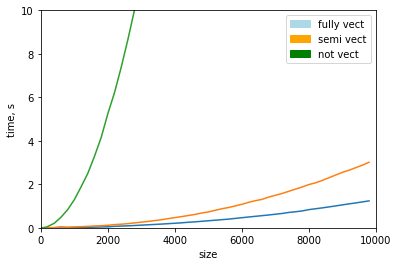

In [20]:
sns.lineplot(y='vectorized',
             x='size',
             data=data.loc[:, ['vectorized', 'size']])
sns.lineplot(y='semi_vectorized',
             x='size',
             data=data.loc[:, ['semi_vectorized', 'size']])
sns.lineplot(y='not_vectorized',
             x='size',
             data=data.loc[:, ['not_vectorized', 'size']])

plt.xlim(0, 10000)
plt.ylim(0, 10)
plt.xlabel('size')
plt.ylabel('time, s')
blue_patch = mpatches.Patch(color='lightblue', label='fully vect')
orange_patch = mpatches.Patch(color='orange', label='semi vect')
green_patch = mpatches.Patch(color='green', label='not vect')
plt.legend(handles=[blue_patch, orange_patch, green_patch])
plt.show()


## Изменим мастштаб графика и посмотрим, что происходит при size <= 25

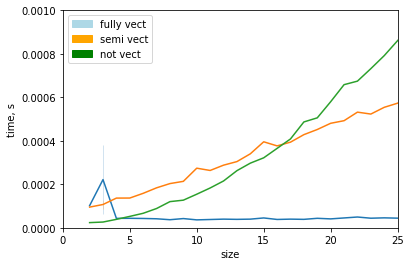

In [36]:
sns.lineplot(y='vectorized',
             x='size',
             data=data.loc[:, ['vectorized', 'size']])

sns.lineplot(y='semi_vectorized', x='size',
             data=data.loc[:, ['semi_vectorized', 'size']])

sns.lineplot(y='not_vectorized',
             x='size',
             data=data.loc[:, ['not_vectorized', 'size']])

plt.xlim(0, 25)
plt.ylim(0, 0.001)
plt.xlabel('size')
plt.ylabel('time, s')
blue_patch = mpatches.Patch(color='lightblue', label='fully vect')
orange_patch = mpatches.Patch(color='orange', label='semi vect')
green_patch = mpatches.Patch(color='green', label='not vect')
plt.legend(handles=[blue_patch, orange_patch, green_patch])
plt.show()

### Почему векторизация работает быстрее, чем циклы для больших размеров матриц?
Дело в том, что с появлением векторных регистров независимые вычисления стало возможно производить параллельно(количество вычислений за одну итерацию зависит от разрядности регистра).  На картинке представлен пример одной итерации сложения матриц **A**, **B**: **a[i] = i**; **b[i] = 100 + 1** для скалярных(синие) и векторных(желтые) регистров.               
![Vectorization](https://msdnshared.blob.core.windows.net/media/MSDNBlogsFS/prod.evol.blogs.msdn.com/CommunityServer.Blogs.Components.WeblogFiles/00/00/01/04/99/1258.Registers.jpg)

### Почему частичная векторизация справляется хуже, чем циклы для матриц размера <= 15?
Мое предположение такое: 

Копирование при column_mean = np.nanmean(X_with_nans[:, j]) происходит не так оптимально при малых размерах матриц.

  * Ссылки:
  
  [What is Vectorization?](https://blogs.msdn.microsoft.com/nativeconcurrency/2012/04/12/what-is-vectorization/)
